# Attention
1. This is the **complete Final Project notebook**.
1. This notebook **may not be able to be run all at once** because the default **memory and GPU resources provided by colab are not enough**, so in addition to this notebook, I have **divided it into two parts** so that testers can **directly run both notebooks separately** to see the results.
2. Also it will **take a long time** to run through all the content, please be patient, or people can **refer to the existing output** which is exactly the same as what you will get after running. Thanks!

# Setup

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  pass

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [30]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.12.0
Version 2, minor 12


In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [29]:
# Derived from: https://stackoverflow.com/a/44210735

import pkg_resources

required = {'scikit-learn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [31]:
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets
!pip install evaluate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
Looking in indexes: https://pypi.org

In [32]:
import transformers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import Dataset, DatasetDict
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, TFDistilBertModel
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops.gen_logging_ops import histogram_summary
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from transformers import get_scheduler
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Discussion

**In each part, or each experiment, I would like to see a Discussion of results**
- **Can you conclude that your choices led to better of worse out of sample performance ?**
- **Do you have a theory as to why the performance changed/did not change ?**

The objective is to get you to think like a scientist rather than just completing a task.

# Basic part of assignment

There are several sub-parts. 
- Fine-tune *only the Classifier head*
- Fine-tune *all* the weights

**You will present a discussion of whether your out of sample performance was significantly improved**
**by one of the two sub-parts.**

The Basic part allows you several simplifications
- your model fitting can take features/labels that are Python data structures
    - these are most familiar to you
    - obtained from the dataset
- you can using a HuggingFace model that already comes with a Classifier head

I suggest that one section of your notebook **clearly demonstrates success on the Basic Part.**
- Walk before you try running
- Extra parts should be distinct suggestions


# Financial PhraseBank dataset

The dataset was created as part of a research paper in Finance.

There were several humans who labeled the sentiment of sentences.  Naturally humans don't always agree.
Thus, the dataset has several "flavors" (called "subsets") based on the fraction of annotators who
agree.

As part of the "basic" assignment, you should use the **"all agree" flavor**.

There are multiple ways to access this dataset.
- The preferred way: as a [HuggingFace dataset](https://huggingface.co/datasets/financial_phrasebank)
- Discouraged: as a [TFDS](https://www.tensorflow.org/datasets/community_catalog/huggingface/financial_phrasebank)
    - this is discouraged *only* because **there will be an "extra" part asking you to convert the HuggingFace dataset to a TFDS**
    - you won't get credit for this "extra" if you obtain it directly as a TFDS !
- Discouraged: From the [authors](https://www.researchgate.net/publication/251231364_FinancialPhraseBank-v10)
    - the "Download the PDF" link contains an archive file with the data
    - this is discouraged only because **it involves extra work**
    - but you might find it **handy in creating your own TFDS in the "extra" part**
    
You don't need to understand the paper but here is a [reference](https://arxiv.org/pdf/1307.5336.pdf#page=9)
to the paper that introduced it.


## Load dataset

In [33]:
dataset_name = "financial_phrasebank"
subset_name = 'sentences_allagree'

label_to_int = { 'negative': 0, 'neutral': 1, 'positive': 2}

(text_hdr, label_hdr) = ("sentence", "label")

dataset = load_dataset(dataset_name, subset_name)['train']
dataset = dataset.shuffle()

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Train test split
- Split the original dataset into proportions of 0.6, 0.2 and 0.2 respectively as trian_dataset, valid_dataset and test_dataset.

In [34]:
train_texts, test_texts, train_labels, test_labels = train_test_split(dataset["sentence"], dataset["label"], test_size=0.2)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.25)

# Choose a Pre-Trained Language Model from the HuggingFace platform

There are lots of Language Models on HuggingFace.  They vary by, among other things
- model size
- training objective
- language of training data

An important consideration is computational
- the model fits in the memory of the machine you are using
- the execution time is rapid enough for you to experiment
    - it will help to have a machine with a GPU (e.g., Google Colab)

You are free to choose *subject to limitations*
- the model should *not* have already been trained on a Financial dataset
    - e.g., you may not use FinBERT

I can verify that the choice of `distilbert-base-uncased` is feasible when using the free version of Google Colab

One of the options for **extra credit is to experiment with different models and report and explain the differences.**

## Load pre-trained model and tokenizer
- Load 'distilbert-base-uncased' pre-trained model and tokenizer.

In [12]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
modelBert_distil = TFDistilBertModel.from_pretrained(checkpoint)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Tokenize and create new dataset
- Tokenize the train/valid/test data respectively to get the input features for models. 
- Then create new dataset which contains both features and labels.

In [ ]:
train_tokens = tokenizer(train_texts, truncation=True, padding = True)
valid_tokens = tokenizer(valid_texts, truncation=True, padding = True)
test_tokens = tokenizer(test_texts, truncation=True, padding = True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    train_labels
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_tokens),
    valid_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens),
    test_labels
))

# Basic - Transfer Learning

### Define training and evaluation functions 
- which can be called directly in the following various experiments.

In [18]:
def train_model(model, train_dataset, valid_dataset, num_epochs=5):
    num_train_steps = len(train_dataset) * num_epochs
    lr_scheduler = PolynomialDecay(
        initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
    )

    model.compile(
        optimizer = Adam(learning_rate=lr_scheduler),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics = ["accuracy"]
    )

    res = model.fit(
      train_dataset.batch(8), 
      validation_data = valid_dataset.batch(8),
      epochs = num_epochs
    )

    return res

In [19]:
def eval_model(model, test_dataset, test_labels):
  test_logits = model.predict(test_dataset.batch(8))

  try:
    # If it is a Hugging Face return type, the logits are in the result attribute 'logits'
      test_logits = test_logits["logits"]
  except:
      pass
  
  test_preds = np.argmax(test_logits, axis=1)

  cf_matrix = confusion_matrix(test_labels, test_preds)
  # Plot confusion matrix
  sns.heatmap(cf_matrix, annot=True)

  res = classification_report(test_labels, test_preds, digits = 4)  
  
  return res

## Fine-tuning - Head only, with auto generated classification head
- Train the weights of the Classification head while holding the weights of the Pre-Trained model constant.

In [ ]:
modelFined_auto = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Set the attribute as False to freeze the weights
modelFined_auto.layers[0].trainable = False

# Get the model summary
modelFined_auto.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_38']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 592,899
Non-trainable params: 66,362,880
_________________________________________________________________


### Compiling and Training

In [ ]:
train_model(modelFined_auto, train_dataset, valid_dataset)

Epoch 1/5
170/170 [==============================] - 30s 58ms/step - loss: 0.8546 - accuracy: 0.6193 - val_loss: 0.7589 - val_accuracy: 0.6711
Epoch 2/5
170/170 [==============================] - 7s 44ms/step - loss: 0.6623 - accuracy: 0.7246 - val_loss: 0.6111 - val_accuracy: 0.7616
Epoch 3/5
170/170 [==============================] - 8s 46ms/step - loss: 0.5696 - accuracy: 0.7563 - val_loss: 0.5377 - val_accuracy: 0.7704
Epoch 4/5
170/170 [==============================] - 7s 42ms/step - loss: 0.5198 - accuracy: 0.7761 - val_loss: 0.4961 - val_accuracy: 0.7770
Epoch 5/5
170/170 [==============================] - 8s 47ms/step - loss: 0.4847 - accuracy: 0.7791 - val_loss: 0.4691 - val_accuracy: 0.7859


### Evaluation: on test data

57/57 [==============================] - 3s 31ms/step

Config: [Distilbert-base-uncased | Auto Head | Train Head Only | All-Agree Dataset(HFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     1.0000    0.0152    0.0299        66
           1     0.8754    0.9745    0.9223       274
           2     0.5646    0.7345    0.6385       113

    accuracy                         0.7748       453
   macro avg     0.8133    0.5747    0.5302       453
weighted avg     0.8160    0.7748    0.7215       453



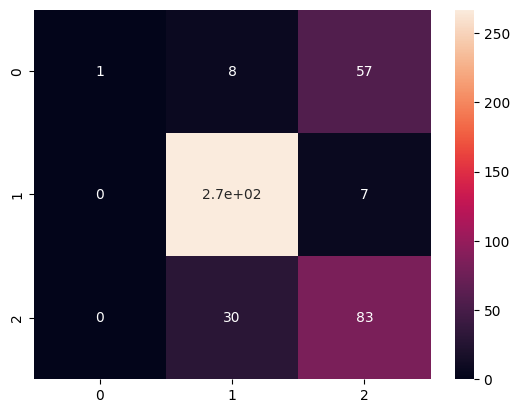

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train Head Only | All-Agree Dataset(HFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_auto, test_dataset, test_labels))

In [ ]:
del modelFined_auto

## Fine tuning - All layers, with auto generated classification head

Hugging Face has a generic TFAutoModelForSequenceClassification class

that invoked the *ForSequenceClassification variant of a given model
result is a model that includes
- the post-processing steps needed to feed a Classification head
- an (uninitialized) Classification Head
  - we need to tell the head how many classes are possible: num_labels argument

In [ ]:
modelFined_all_auto = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

modelFined_all_auto.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_184']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_184 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


As is shown above, since all weights are trainable, it's better to train the classification head first before fine-tuning all the layers.  
First see the layer structure.


### Compiling and Training

In [ ]:
train_model(modelFined_all_auto, train_dataset, valid_dataset)

Epoch 1/5
170/170 [==============================] - 51s 163ms/step - loss: 0.3637 - accuracy: 0.8623 - val_loss: 0.2123 - val_accuracy: 0.9338
Epoch 2/5
170/170 [==============================] - 16s 92ms/step - loss: 0.0963 - accuracy: 0.9676 - val_loss: 0.2002 - val_accuracy: 0.9448
Epoch 3/5
170/170 [==============================] - 16s 92ms/step - loss: 0.0394 - accuracy: 0.9875 - val_loss: 0.2611 - val_accuracy: 0.9426
Epoch 4/5
170/170 [==============================] - 16s 94ms/step - loss: 0.0341 - accuracy: 0.9860 - val_loss: 0.2418 - val_accuracy: 0.9448
Epoch 5/5
170/170 [==============================] - 16s 95ms/step - loss: 0.0164 - accuracy: 0.9941 - val_loss: 0.2852 - val_accuracy: 0.9426


### Evaluation: on test data

57/57 [==============================] - 3s 31ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(HFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9677    0.9091    0.9375        66
           1     0.9963    0.9745    0.9852       274
           2     0.9024    0.9823    0.9407       113

    accuracy                         0.9669       453
   macro avg     0.9555    0.9553    0.9545       453
weighted avg     0.9687    0.9669    0.9672       453



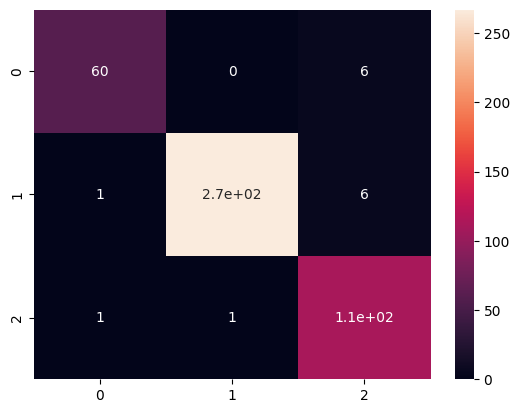

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(HFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_all_auto, test_dataset, test_labels))

In [ ]:
# del modelFined_all_auto

## Conclusion
- Comparing the two experiments in basic part, it's obvious to tell that traing all weights makes the model perform much better than training only the classification head. 
- This is because the pre-trained model is not specialized for tasks of sentiment analysis. Adding a head and simply train it could not make a big difference to the original attributes of pre-trained model, thus leading to a relatively low accuracy (around 0.8).
- By unfreezing all the weights, including those belong to the pre-trained model, the final model can better adapt to the new task and the financial dataset, thus performing much better.
- In addition, it is important to notice that when training the head only, the errors of classifying label 0 are obvious. The model could not handle those negative labels, probably due to the imbalanced data.
- Some other errors reflected on the confusion matrix will be further discussed in the extra parts.



# Extras

You can demonstrate greater skill (and earn more points) by completing some extra parts.

After each extra, please complete a Discussion section as you did for the Basic part.

My suggestions follow, but I'm open to your ideas.

I will determine the amount of extra points by my perception of the difficulty of each extra.

## 1.Create (and fit the model with) a TensorFlow Dataset (TFDS)

*Relative difficulty*: low to medium

The dataset is sufficiently small to fit into memory on a free Google Colab machine.

In this part, I want you to *pretend* that your machine is not big enough to fit all the data into memory.

You will create a TFDS and use this in the model fitting.


*Starting off with the HuggingFace dataset*, create a TFDS with the same data
- use this TFDS in the "fit" statement of the model
    - manipulate the data as much as possible using TFDS operations
        - e.g., if you need to shuffle the examples, use TFDS operations rather than shuffling before creating the TFDS
    - it's OK to load the entire HuggingFace dataset into memory for the purpose of creating the TFDS
- *you may not start off with a dataset that is already a TFDS*

The objective is for you to demonstrate skill with TFDS.

### Define convert functions

In [9]:
def hf2tfds(dataset, tokenizer):
    tokens = tokenizer(dataset["sentence"], padding=True, return_tensors="np")
    labels = np.array(dataset["label"])

    dataset_tf = tf.data.Dataset.from_tensor_slices((
          dict(tokens), 
          labels
        ))

    return dataset_tf

  
def tdfs_split(dataset_tf):
    # Split the dataset into training and validation datasets
    test_dataset_tf = dataset_tf.take(int(len(dataset) * 0.2))
    train_dataset_tf = dataset_tf.skip(int(len(dataset) * 0.2))

    valid_dataset_tf = train_dataset_tf.take(int(len(dataset) * 0.2))
    train_dataset_tf = train_dataset_tf.skip(int(len(dataset) * 0.2))

    return train_dataset_tf, valid_dataset_tf, test_dataset_tf

### Define new training function 
For TFDS, we define a new function for model training. The difference between this and the previous one is that it calls the 'shuffle()' and 'batch()' methodss during the model fitting process, rather than preprocessing it before fitting. These are some particular operations of TFDS, which cannot be applied on HuggingFace dataset.  

In [10]:
def train_model_TFDS(model, train_dataset_tf, valid_dataset_tf, num_epochs=5):

    num_train_steps = len(train_dataset_tf) * num_epochs
    lr_scheduler = PolynomialDecay(
        initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
    )

    model.compile(
        optimizer = Adam(learning_rate=lr_scheduler),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics = ["accuracy"]
    )

    res = model.fit(
      # Call shuffle and batch methods of TFDS
      train_dataset_tf.shuffle(1000).batch(8), 
      validation_data = valid_dataset_tf.batch(8),
      epochs = num_epochs
    )

    return res

### Convert HF dataset to TFDS and split dataset
- In all the following sessions, we all use TFDS rather than HuggingFace Dataset.

In [13]:
dataset_tf = hf2tfds(dataset, tokenizer)
train_dataset_tf, valid_dataset_tf, test_dataset_tf = tdfs_split(dataset_tf)
test_labels_tf = np.array([y for x, y in test_dataset_tf])

### Compiling and Training
- Here we only test the availability of generated TFDS by training all the weights instead of comparing the performance of 'Train all layers' and 'Train only head'. 

In [ ]:
modelFined_auto_tf = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

modelFined_auto_tf.summary()

train_model_TFDS(modelFined_auto_tf, train_dataset_tf, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_78', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_78 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
170/170 [==============================] - 58s 200ms/step - loss: 

### Evaluation: on test data

57/57 [==============================] - 4s 46ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.8667    0.9630    0.9123        54
           1     0.9713    0.9748    0.9731       278
           2     0.9558    0.9000    0.9270       120

    accuracy                         0.9535       452
   macro avg     0.9312    0.9459    0.9375       452
weighted avg     0.9547    0.9535    0.9536       452



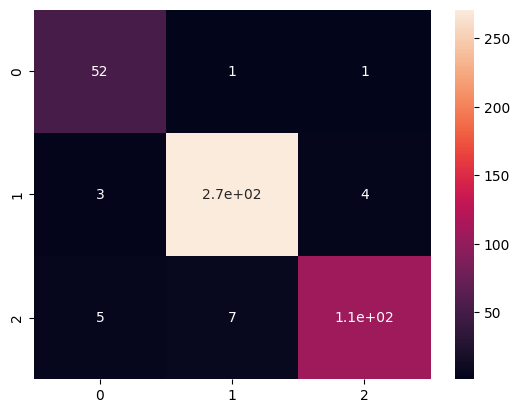

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_auto_tf, test_dataset_tf, test_labels_tf))

In [ ]:
del modelFined_auto_tf

## 2.Create your own Classification head

*Relative difficulty*: medium to hard

Rather than using a Classification head automatically provided with the HuggingFace model
- you will obtain a head-less model from HugginFace
- you will add your own Classification head
    - with as many layers as you like
    
The objective is for you to demonstrate some skills with the Keras Functional Model API.

We will accomplish this by deriving a sub-class of `kera.Model`
- that *contains* a `DistilBert` model
  - refered to as the "encoder"
- override the `call` method
  - to invoke the encoder
  - post-process the output (obtain the encoding of the special `[CLS]` input token
  - use the encoding of `[CLS]` as input to a task-specfiic Classifier head

### Define own model class

In [ ]:
class TextClassificationModel(keras.Model):
  def __init__(self, encoder, train_encoder=True):
    super(TextClassificationModel, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = train_encoder
    self.dropout1 = layers.Dropout(0.1)
    self.dropout2 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(20, activation="relu")
    self.dense2 = layers.Dense(3)
  
  def call(self, input):
    x = self.encoder(input)
    x = x['last_hidden_state'][:, 0, :]
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    return x


### Fine tuning - Head only with own classification head
Unfreeze the weights of the Pre-Trained model and allow them to adapt to the assignment's task
Now that the head has been trained, it's safe to update weights for the "Encoder".

Had we not trained the head first:
- the gradients in the initial batches would have been large
- and updateing the Encoder weights with these large gradients would have been harmful


#### Compiling and Training

In [ ]:
# create new model
modelFined = TextClassificationModel(modelBert_distil, train_encoder=False)

train_model_TFDS(modelFined, train_dataset_tf, valid_dataset_tf)

modelFined.summary()

Epoch 1/5
170/170 [==============================] - 22s 81ms/step - loss: 0.9271 - accuracy: 0.6037 - val_loss: 0.8748 - val_accuracy: 0.6173
Epoch 2/5
170/170 [==============================] - 12s 68ms/step - loss: 0.8469 - accuracy: 0.6140 - val_loss: 0.8117 - val_accuracy: 0.6173
Epoch 3/5
170/170 [==============================] - 12s 68ms/step - loss: 0.7890 - accuracy: 0.6559 - val_loss: 0.7432 - val_accuracy: 0.6637
Epoch 4/5
170/170 [==============================] - 11s 67ms/step - loss: 0.7293 - accuracy: 0.6993 - val_loss: 0.6926 - val_accuracy: 0.6969
Epoch 5/5
170/170 [==============================] - 11s 67ms/step - loss: 0.6843 - accuracy: 0.7243 - val_loss: 0.6586 - val_accuracy: 0.7301
Model: "text_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model (TFDis  multiple                 66362880  
 tilBertModel)                                      

In [ ]:
for i, layer in enumerate( modelFined.layers[-2:] ):
    print(f"Layer {-2 + i}: {type(layer)} weights {layer.weights[0].shape}, biases {layer.weights[1].shape}")

Layer -2: <class 'keras.layers.core.dense.Dense'> weights (768, 20), biases (20,)
Layer -1: <class 'keras.layers.core.dense.Dense'> weights (20, 3), biases (3,)


See the below results, showing weights of the last two dense layers that we added to fine the pre-trained model.
- the latent representation size of the pre-trained model (of the single `[CLS]` token) is 768
- the next to last layer is `Dense`, converts 768 to 20 new created features
- the last layer (Classifier) converts 20 features to 3 classes (lables)


#### Evaluation: on test data

57/57 [==============================] - 5s 48ms/step

Config: [Distilbert-base-uncased | Own Head | Train Head Only | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        54
           1     0.7803    0.9712    0.8654       278
           2     0.5472    0.4833    0.5133       120

    accuracy                         0.7257       452
   macro avg     0.4425    0.4849    0.4596       452
weighted avg     0.6252    0.7257    0.6685       452



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


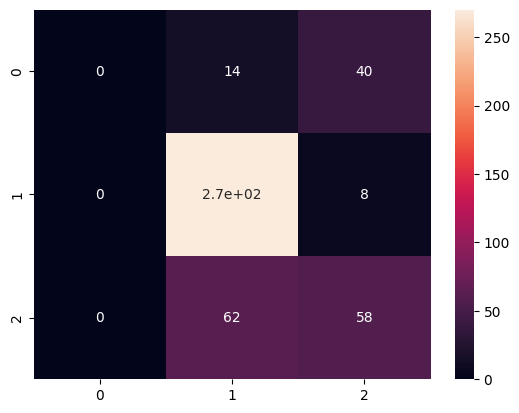

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Own Head | Train Head Only | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined, test_dataset_tf, test_labels_tf))

In [ ]:
del modelFined

### Fine tuning - All layers with own classification head
Unfreeze the weights of the Pre-Trained model and allow them to adapt to the assignment's task
Now that the head has been trained, it's safe to update weights for the "Encoder".

Had we not trained the head first:
- the gradients in the initial batches would have been large
- and updateing the Encoder weights with these large gradients would have been harmful

#### Compiling and Training


In [ ]:
# create new model
modelFined_all = TextClassificationModel(modelBert_distil, train_encoder=True)

train_model_TFDS(modelFined_all, train_dataset_tf, valid_dataset_tf)

modelFined_all.summary()

Epoch 1/5
170/170 [==============================] - 61s 216ms/step - loss: 0.3714 - accuracy: 0.8618 - val_loss: 0.2272 - val_accuracy: 0.9159
Epoch 2/5
170/170 [==============================] - 25s 149ms/step - loss: 0.1341 - accuracy: 0.9632 - val_loss: 0.1090 - val_accuracy: 0.9602
Epoch 3/5
170/170 [==============================] - 28s 165ms/step - loss: 0.0475 - accuracy: 0.9787 - val_loss: 0.2849 - val_accuracy: 0.9425
Epoch 4/5
170/170 [==============================] - 26s 154ms/step - loss: 0.0453 - accuracy: 0.9824 - val_loss: 0.2655 - val_accuracy: 0.9602
Epoch 5/5
170/170 [==============================] - 25s 149ms/step - loss: 0.0505 - accuracy: 0.9801 - val_loss: 0.1911 - val_accuracy: 0.9535
Model: "text_classification_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model (TFDis  multiple                 66362880  
 tilBertModel)                               

#### Evaluation: on test data

57/57 [==============================] - 4s 46ms/step

Config: [Distilbert-base-uncased | Own Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9107    0.9444    0.9273        54
           1     0.9579    0.9820    0.9698       278
           2     0.9730    0.9000    0.9351       120

    accuracy                         0.9558       452
   macro avg     0.9472    0.9422    0.9440       452
weighted avg     0.9563    0.9558    0.9555       452



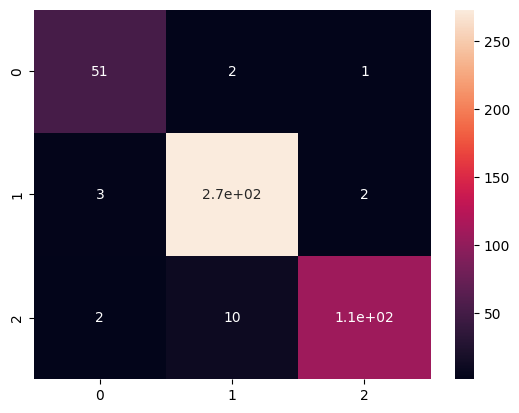

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Own Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n" , eval_model(modelFined_all, test_dataset_tf, test_labels_tf))

In [ ]:
del modelFined_all

### Conclusion
- Unfortunately, the above models with self-created classification head didn't overtake the auto-generated models respectively when training head only or all the layers.
- The basic rule remains the same that training all layers is better than just training the classification head. Therefore in the following sessions, if not required, I will just train the unfreezed fine-tuned models without comparing with training head only anymore.
- This result makes sense because I didn't think too much about the reasonality of the layers I added, where a lot of adjustments and considerations can be made. While behind the auto API, there must be a logic of generationg layers and classification head, which is likely more reasonable and adaptable than self-created ones. Otherwise, it wouldn't be such a successful package and an API.

## 3.Use different "flavors" of the dataset

*Relative difficulty*: low, but time-consuming

The basic part used examples on which all annotators agreed.

Try different flavors and discuss the results.

### Load dataset

In [24]:
dataset_name = "financial_phrasebank"
subset_name_50 = 'sentences_50agree'
subset_name_66 = 'sentences_66agree'
subset_name_75 = 'sentences_75agree'

dataset_50 = load_dataset(dataset_name, subset_name_50)['train'].shuffle()
dataset_66 = load_dataset(dataset_name, subset_name_66)['train'].shuffle()
dataset_75 = load_dataset(dataset_name, subset_name_75)['train'].shuffle()

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### Train test split

In [25]:
dataset_tf_50 = hf2tfds(dataset_50, tokenizer)
train_dataset_tf_50, valid_dataset_tf_50, test_dataset_tf_50 = tdfs_split(dataset_tf_50)
test_labels_tf_50 = np.array([y for x, y in test_dataset_tf_50])

dataset_tf_66 = hf2tfds(dataset_66, tokenizer)
train_dataset_tf_66, valid_dataset_tf_66, test_dataset_tf_66 = tdfs_split(dataset_tf_66)
test_labels_tf_66 = np.array([y for x, y in test_dataset_tf_66])

dataset_tf_75 = hf2tfds(dataset_75, tokenizer)
train_dataset_tf_75, valid_dataset_tf_75, test_dataset_tf_75 = tdfs_split(dataset_tf_75)
test_labels_tf_75 = np.array([y for x, y in test_dataset_tf_75])

del dataset_50
del dataset_66
del dataset_75

### Create models
- Because in the previous experiments, we have found that training all the weights performs much better than just training the classification head, which is reasonable and explainable as well. Therefore in the following sessions, we will train all weights by default and will not compare the performance with only training head if not required.

In [ ]:
# create new models
modelFined_50 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_66 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_75 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_104', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

### Use 50-agree dataset

In [ ]:
train_model_TFDS(modelFined_50, train_dataset_tf_50, valid_dataset_tf_50)

Epoch 1/5
493/493 [==============================] - 102s 160ms/step - loss: 0.5215 - accuracy: 0.7884 - val_loss: 0.3733 - val_accuracy: 0.8363
Epoch 2/5
493/493 [==============================] - 68s 138ms/step - loss: 0.2663 - accuracy: 0.9021 - val_loss: 0.3884 - val_accuracy: 0.8451
Epoch 3/5
493/493 [==============================] - 69s 140ms/step - loss: 0.1468 - accuracy: 0.9485 - val_loss: 0.6266 - val_accuracy: 0.7942
Epoch 4/5
493/493 [==============================] - 70s 141ms/step - loss: 0.0915 - accuracy: 0.9731 - val_loss: 0.6185 - val_accuracy: 0.8407
Epoch 5/5
493/493 [==============================] - 69s 140ms/step - loss: 0.0708 - accuracy: 0.9795 - val_loss: 0.6923 - val_accuracy: 0.7810


57/57 [==============================] - 5s 54ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 50-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.6491    0.7708    0.7048        48
           1     0.9286    0.7619    0.8370       273
           2     0.6667    0.8702    0.7550       131

    accuracy                         0.7942       452
   macro avg     0.7481    0.8010    0.7656       452
weighted avg     0.8230    0.7942    0.7992       452



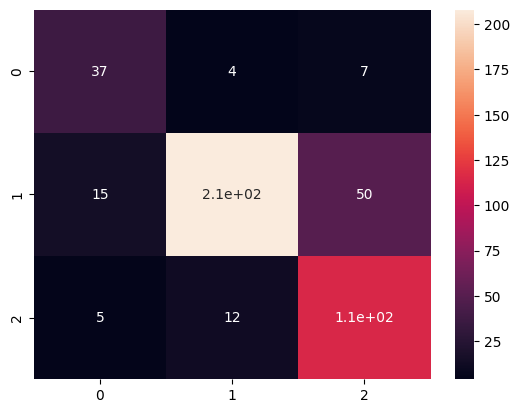

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 50-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_50, test_dataset_tf_50, test_labels_tf_50))

In [ ]:
del modelFined_50

### Use 66-agree dataset

In [ ]:
train_model_TFDS(modelFined_66, train_dataset_tf_66, valid_dataset_tf_66)

Epoch 1/5
415/415 [==============================] - 92s 165ms/step - loss: 0.4621 - accuracy: 0.8276 - val_loss: 0.2848 - val_accuracy: 0.8805
Epoch 2/5
415/415 [==============================] - 61s 146ms/step - loss: 0.1858 - accuracy: 0.9336 - val_loss: 0.3293 - val_accuracy: 0.8850
Epoch 3/5
415/415 [==============================] - 59s 142ms/step - loss: 0.1065 - accuracy: 0.9653 - val_loss: 0.3756 - val_accuracy: 0.8805
Epoch 4/5
415/415 [==============================] - 62s 148ms/step - loss: 0.0567 - accuracy: 0.9807 - val_loss: 0.4445 - val_accuracy: 0.8960
Epoch 5/5
415/415 [==============================] - 59s 142ms/step - loss: 0.0495 - accuracy: 0.9840 - val_loss: 0.4099 - val_accuracy: 0.8872


57/57 [==============================] - 4s 47ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 66-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.7895    0.8182    0.8036        55
           1     0.8944    0.9304    0.9120       273
           2     0.8559    0.7661    0.8085       124

    accuracy                         0.8717       452
   macro avg     0.8466    0.8382    0.8414       452
weighted avg     0.8710    0.8717    0.8704       452



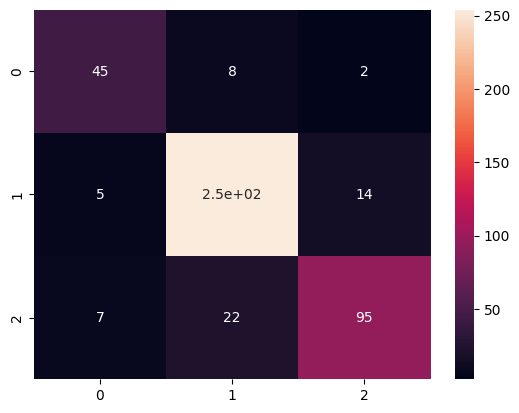

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 66-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_66, test_dataset_tf_66, test_labels_tf_66))

In [ ]:
del modelFined_66

### Use 75-agree dataset

In [ ]:
train_model_TFDS(modelFined_75, train_dataset_tf_75, valid_dataset_tf_75)

Epoch 1/5
319/319 [==============================] - 79s 175ms/step - loss: 0.3886 - accuracy: 0.8631 - val_loss: 0.2398 - val_accuracy: 0.9159
Epoch 2/5
319/319 [==============================] - 47s 146ms/step - loss: 0.1397 - accuracy: 0.9514 - val_loss: 0.3066 - val_accuracy: 0.9004
Epoch 3/5
319/319 [==============================] - 46s 145ms/step - loss: 0.0691 - accuracy: 0.9780 - val_loss: 0.2356 - val_accuracy: 0.9336
Epoch 4/5
319/319 [==============================] - 46s 145ms/step - loss: 0.0455 - accuracy: 0.9827 - val_loss: 0.3184 - val_accuracy: 0.9204
Epoch 5/5
319/319 [==============================] - 46s 144ms/step - loss: 0.0360 - accuracy: 0.9878 - val_loss: 0.3338 - val_accuracy: 0.9004


57/57 [==============================] - 5s 46ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9091    0.8824    0.8955        68
           1     0.9380    0.9414    0.9397       273
           2     0.8482    0.8559    0.8520       111

    accuracy                         0.9115       452
   macro avg     0.8984    0.8932    0.8957       452
weighted avg     0.9116    0.9115    0.9115       452



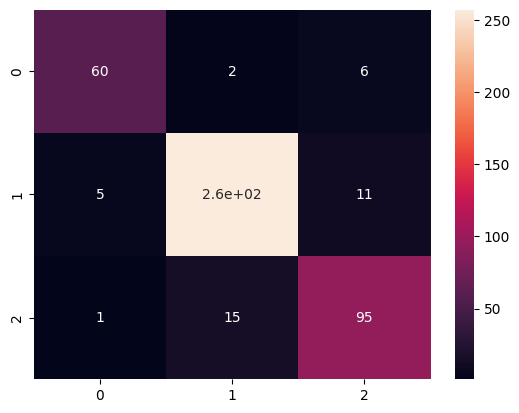

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_75, test_dataset_tf_75, test_labels_tf_75))

In [ ]:
del modelFined_75

### Conclusion
- It is obvious that the accuracy increases with the increase of level of agreement, which is super intuitive because the more consistent people are in classifying the phrase, the less confusing the phrase would be. So it is much easier for the experts to label the data, so do the trained models.

## 4.Address any Imbalanced Data issues

*Relative difficulty: low*

- If the distribution between labels in the dataset is not uniform, you may want to address the imbalance

**Here we use the allagree subset as an example and use the autogenerated model with all layers trainable.**


(array([ 66.,   0.,   0.,   0.,   0., 274.,   0.,   0.,   0., 113.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

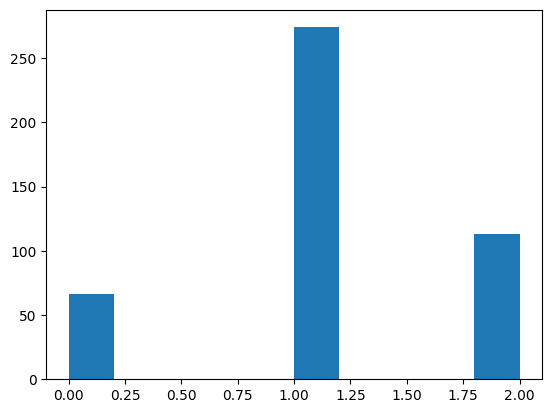

In [ ]:
import matplotlib.pyplot as plt

plt.hist(test_labels)

In [ ]:
len(test_labels)

453

### Use various metrics
- This has already been considered and implemented before in the eval_model() function. Besides accuracy, we take other metrics into account, such as f1-score, precision, and we print out the confusion matrix as well. Therefore we can avoid overlooking the problems caused by imbalanced data to some extent.



### Oversampling

- Another method to solve the imbalanced data problem is simply to make it balanced through resampling. Here we will apply the oversampling method, which will generate random samples of those minor labels, and to make them reach to the same amount as the major label.

(array([850.,   0.,   0.,   0.,   0., 850.,   0.,   0.,   0., 850.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

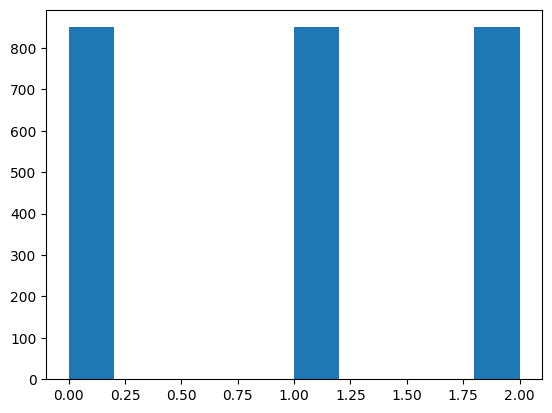

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
train_texts_re, train_labels_re = ros.fit_resample(np.array(train_texts).reshape(-1,1), train_labels)
train_texts_re = list(map(lambda x: x[0], train_texts_re))

plt.hist(train_labels_re)

In [ ]:
def texts_labels2tfds(texts, labels):
    tokens = tokenizer(texts, padding=True, return_tensors="np")
    labels = np.array(labels)

    dataset_tf = tf.data.Dataset.from_tensor_slices((
          dict(tokens), 
          labels
        ))
    dataset_tf = dataset_tf.shuffle(len(dataset))

    return dataset_tf

# Get resampled train dataset
train_dataset_tf_re = texts_labels2tfds(train_texts_re, train_labels_re)
del train_texts_re
del train_labels_re

### Compiling and Training

In [ ]:
modelFined_auto_re = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_auto_re.layers[0].trainable = False

train_model_TFDS(modelFined_auto_re, train_dataset_tf_re, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_164', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5
319/319 [==============================] - 23s 48ms/step - loss: 0.9280 - accuracy: 0.6086 - val_loss: 0.6688 - val_accuracy: 0.7611
Epoch 2/5
319/319 [==============================] - 13s 40ms/step - loss: 0.6959 - accuracy: 0.7173 - val_loss: 0.5087 - val_accuracy: 0.8164
Epoch 3/5
319/319 [==============================] - 13s 40ms/step - loss: 0.5972 - accuracy: 0.7557 - val_loss: 0.4503 - val_accuracy: 0.8473
Epoch 4/5
319/319 [==============================] - 13s 40ms/step - loss: 0.5305 - accuracy: 0.8004 - val_loss: 0.3864 - val_accuracy: 0.8584
Epoch 5/5
319/319 [==============================] - 12s 39ms/step - loss: 0.4884 - accuracy: 0.8216 - val_loss: 0.3824 - val_accuracy: 0.8496


### Evaluation: on test data

57/57 [==============================] - 5s 54ms/step

Config: [Distilbert-base-uncased | Auto Head | Train Head Only | All-Agree Dataset(TFDS) | With Resampling]
Result:
               precision    recall  f1-score   support

           0     0.6825    0.7963    0.7350        54
           1     0.9380    0.8705    0.9030       278
           2     0.7023    0.7667    0.7331       120

    accuracy                         0.8341       452
   macro avg     0.7743    0.8112    0.7904       452
weighted avg     0.8449    0.8341    0.8378       452



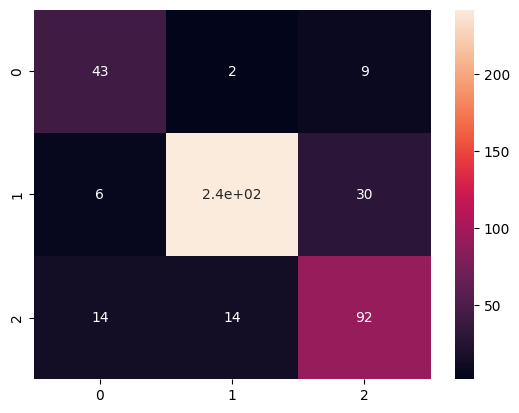

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train Head Only | All-Agree Dataset(TFDS) | With Resampling]\nResult:\n", eval_model(modelFined_auto_re, test_dataset_tf, test_labels_tf))

In [ ]:
del modelFined_auto_re

### Conclusion
- Compared to the results in all the previous experiments, especially those that only train the classification head, the after oversampling model improves a lot in performance in all dimensions, which is super amazing. It perfectly handles the mislabeling problems of the negative lebel data that we mentioned before.

## 5.Superior Error Analysis

*Relative difficulty: medium*

Rather than just reporting a single summary statistic for out of sample performance, analyze the results in detail
- Is one class harder to correctly classify than others
- Is there some systematic pattern of errors
    - e.g., characteristics of input sentences that are more difficult to correctly classify
    
Try to use the results of this analysis to improve the model

### Observations and intuitive analysis

1. Using the distilbert model, when training classification head only, both negative and positive labels are likely to be classified as neutral. This is somehow explainable and reasonable because the distilbert model itself is not for the task of sentiment analysis but for mask prediction, thus the predicted mask is supposed to be a neutral word in most of the cases. It would be hard to conduct sentiment analysis by training the head only. While training all the layers (weights) can siginificantly improve the accuracy.

2. However, when training all the weights, some other errors still exist which can be seen in almost all the experiment results (see the confusion matrix) :
- **negative labels are relatively more difficult to be correctly classified** compared to the other two labels
- **negative labels are very likely to be classified as positive, which is quite unexpected**
- **positive labels are likely to be misclassified as neutral and negative**
- **neutral labels can be classified as positive as well** 

3. Although it seems that negative labels are more easily messed in the basic part experiments, after solving the imbalanced data problem, we could see that the negative labels are no longer hard to be classified, from which we could **conclude that the errors of mislabeling negative examples are basically caused by imbalanced training data**.

4. However, even after oversampling, there still exist some confusion between neutral labels and positive labels. So, actually the deepest problem is to distinguish between neutral and positive sentences, rather than distinguishing negative from the other two.  

From the observations and analysis above, we will then **focus on figuring out what happened to those mislabeled examples that are in fact neutral or positive (we will check negative labels as well)**.

### Show the mislabeled examples

In [ ]:
test_preds = np.argmax(modelFined_all_auto.predict(test_dataset.batch(8))["logits"],axis=1)
mislabel_index = np.where(test_preds != test_labels)[0]

mislabel_index

57/57 [==============================] - 2s 32ms/step


array([ 18,  56,  85,  97, 111, 149, 152, 161, 166, 253, 277, 302, 363,
       376, 404])

In [ ]:
import pandas as pd
df_mislabeled = pd.DataFrame(data={"sentences":np.array(test_texts)[mislabel_index], 
                                   "true label":np.array(test_labels)[mislabel_index], 
                                   "predict label":np.array(test_preds)[mislabel_index]},
                              index=mislabel_index)
df_mislabeled = df_mislabeled.sort_values(by="true label")
df_mislabeled

,sentences,true label,predict label
56,11 August 2010 - Finnish measuring equipment m...,0,2
97,The result will also be burdened by increased ...,0,2
161,"Earlier today , Geberit 's Finnish rival Upono...",0,2
166,"ADP News - Apr 22 , 2009 - Finnish business in...",0,2
363,Cerberus Capital Management LP-backed printing...,0,2
376,Finnish business software group AffectoGenimap...,0,2
18,The company has decided to stop the operations...,1,0
85,"Previously , the company expected its 2008 fin...",1,2
149,Once your plants are in the ground they will c...,1,2
152,Another firm Air Liquide was exempted because ...,1,2


### Deep dive into examples for further analysis

#### Analysis 1: about tokenizer

- Now let's first take the first 'negative' sentence as an example to see how the current tokenizer encodes the sentence and what the tokens are, by showing 'input ids', 'attention mask', 'decode tokens'.

In [ ]:
print("input ids: \n", np.array(test_tokens["input_ids"])[350])
print("\nattention mask: \n", np.array(test_tokens["attention_mask"])[350])

input ids: 
 [  101  2104  1996  3066  1010  2113  2009  2097  3477  7367  2243 21057
  2213  1006 13751 12521  1012  1022  1049  1011  7327  2099  2620  1012
  1020  1049  1007  1999  5356  1998  4518  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]

attention mask: 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


- Then show the decoded tokens one by one. 

In [ ]:
for x in np.array(test_tokens["input_ids"])[350]:
  print(tokenizer.decode(x))

[CLS]
under
the
deal
,
know
it
will
pay
se
##k
##90
##m
(
usd
##12
.
8
m
-
eu
##r
##8
.
6
m
)
in
cash
and
stock
.
[SEP]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]
[PAD]


##### Conclusion 1.1
- From the above results, we can find that the most directional phrases for sentiment analysis, **'will not pay compensation', are split into 4 independent tokens. ** 
- What I guess from this phenomenon is that though it is originally negative as a phrase, it could be probably detected as neutral because the independent token 'compensation', which sounds like a vote for positivity. 
- The model might ignore the coherence between the contexts. Therefore, the word 'not' might count for negativity, but it would be neutralize by the word 'compensation'.  

**To conclude, the first reason might be the the non-applicability of the current tokenizer. And the solution could be introducing another tokenizer.**

Therefore, I wil call another tokenizer, which i mentioned above, to help generate the tokens and train the model again to see if the results will be better.

In [ ]:
tokenizer_fast = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_tokens_fast = tokenizer_fast(train_texts, truncation=True, padding = True)
valid_tokens_fast = tokenizer_fast(valid_texts, truncation=True, padding = True)
test_tokens_fast = tokenizer_fast(test_texts, truncation=True, padding = True)

train_dataset_fast = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens_fast),
    train_labels
))
valid_dataset_fast = tf.data.Dataset.from_tensor_slices((
    dict(valid_tokens_fast),
    valid_labels
))
test_dataset_fast = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens_fast),
    test_labels
))

del train_tokens_fast
del valid_tokens_fast
del test_tokens_fast

In [ ]:
modelFined_auto_fast = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model(modelFined_auto_fast, train_dataset_fast, valid_dataset_fast)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_204', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5
170/170 [==============================] - 52s 173ms/step - loss: 0.3589 - accuracy: 0.8719 - val_loss: 0.2328 - val_accuracy: 0.9294
Epoch 2/5
170/170 [==============================] - 16s 94ms/step - loss: 0.1399 - accuracy: 0.9536 - val_loss: 0.1784 - val_accuracy: 0.9382
Epoch 3/5
170/170 [==============================] - 16s 93ms/step - loss: 0.0539 - accuracy: 0.9809 - val_loss: 0.1731 - val_accuracy: 0.9536
Epoch 4/5
170/170 [==============================] - 18s 108ms/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.2029 - val_accuracy: 0.9603
Epoch 5/5
170/170 [==============================] - 16s 95ms/step - loss: 0.0123 - accuracy: 0.9978 - val_loss: 0.2240 - val_accuracy: 0.9558


57/57 [==============================] - 3s 32ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(HFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9836    0.9091    0.9449        66
           1     0.9927    0.9891    0.9909       274
           2     0.9244    0.9735    0.9483       113

    accuracy                         0.9735       453
   macro avg     0.9669    0.9572    0.9613       453
weighted avg     0.9743    0.9735    0.9735       453



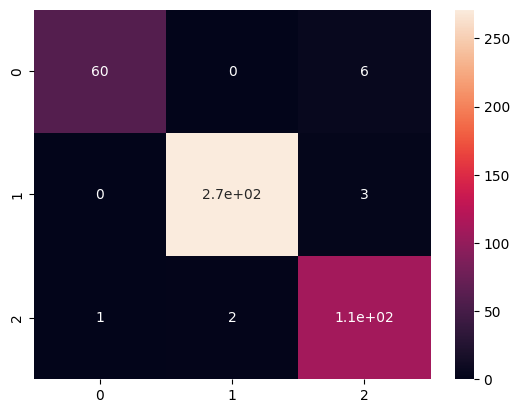

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(HFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_auto_fast, test_dataset_fast, test_labels))

In [ ]:
del modelFined_auto_fast

##### Conclusion 1.2
- As shown in the above results, different tokenizer does influence the final classification results. However, in this experiment, the performance does not improve much compared to that in the basic part. The accuracy of label 2 examples increase while the accuracy of label 0 examples decrease. This is probably because the two tokenizers are both from the same pre-trained model and they are very similar. 

- However, this at least indicates that the selection of tokenizer is also important and will influence the final results. If possible, it would be better to use a specialized tokenizer for financial phrases.
- Or we can consider **add some multi-word tokens (Bigrams, Trigrams, Ngrams)** to preserve the meaning of nultiple words as a whole.

#### Analysis 2: about model logits output and training process

- Now let's mainly take a look at the **'neutral' and 'positive'** examples.
- At the first glance, they seem neutral and there are no obvious signs for both negativity and positivity, but they are somehow classified as positive.
- **My guess is that the predicted logits of 'neutral' and 'positive' are so close** that the models almost made it but still failed at last. 
- In addition, the lack of training and inappropiate hyper parameters may also be a reason. 

Now let's verify by showing the logits of each label.

In [ ]:
# get the example index of each label
target0_index = np.array(df_mislabeled.loc[df_mislabeled['true label']==0]['true label'].index)
target1_index = np.array(df_mislabeled.loc[df_mislabeled['true label']==1]['true label'].index)
target2_index = np.array(df_mislabeled.loc[df_mislabeled['true label']==2]['true label'].index)

test_logits = modelFined_all_auto.predict(test_dataset.batch(8))["logits"]

57/57 [==============================] - 2s 32ms/step


Logits of label 0 examples

In [ ]:
test_logits[target0_index]

array([[-2.2164097 , -3.1934416 ,  4.945264  ],
       [-2.1792228 , -1.3575436 ,  3.3493319 ],
       [ 0.42026213, -3.9451928 ,  3.0870235 ],
       [-2.1678402 , -3.2390106 ,  4.9338465 ],
       [-1.3290279 , -2.3916476 ,  3.2252774 ],
       [-2.022739  , -3.377587  ,  4.869979  ]], dtype=float32)

Logits of label 1 examples

In [ ]:
test_logits[target1_index]

array([[ 1.5613003 ,  0.45423633, -2.3838928 ],
       [-2.147031  , -1.2511202 ,  3.106958  ],
       [-2.382253  ,  1.213376  ,  1.2528028 ],
       [-1.9462844 , -2.5980923 ,  4.181275  ],
       [-1.9817328 , -2.2185671 ,  3.798613  ],
       [-2.578071  , -2.050697  ,  4.338471  ],
       [-1.7039621 , -2.4657083 ,  3.79817   ]], dtype=float32)

Logits of label 2 examples

In [ ]:
test_logits[target2_index]

array([[ 2.6935496 , -3.8103764 ,  0.55878985],
       [-1.9813306 ,  4.3084297 , -2.3448906 ]], dtype=float32)

##### Conclusion 2.1
- From the above results, we can find that far from my expectations, the logits of true labels and predicted labels are not close at all! which is a bit confusing and disappointing.
- Although these examples are mislabeled as another label according to the resulted logits, **the logit of true label ranks second for all these examples, which means the true labels are the second choice of the model.**
- However, this is still an acceptable result because at least it's not the worst case that the true label is the last choice of classification models. 
- Considering that we didn't adjust the hyper parameters much and didn't tried as many experiments as we can, for example **adjusting the numbers of epoch, batch size, learning rate etc, the performance is very likely to improve by adjusting more parameters and training for more epochs**, so that the weights will be adjusted as well, making the true label ultimately the first choice.

**To conclude, the second reason might be the insufficiency of training, which could be solved by adjusting the parameters and training for more time to adjust weights.**

## 6.Experiment with different Pre-Trained models

*Relative difficulty*: low, but time-consuming

Try several different pre-trained Language Models.

Discuss the results.  For example
- does a bigger pre-trained model lead to better results
    - before and after fine-tuning all the weights
- does the type of data on which the model was trained make a difference

### Use 'bert-base-uncased'
- Here we try a larger but similar pre-trained model 'bert-base-uncased'
- Remember to again create new train/valid/test dataset using the new tokenizers.

#### Tokenize and create new dataset

In [ ]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

dataset_bert_tf = hf2tfds(dataset, tokenizer_bert)
train_dataset_bert_tf, valid_dataset_bert_tf, test_dataset_bert_tf = tdfs_split(dataset_bert_tf)
test_labels_bert_tf = np.array([y for x, y in test_dataset_bert_tf])

del dataset_bert_tf

#### Fine-tuning - Head only, with auto generated classification head
Train the weights of the Classification head while holding the weights of the Pre-Trained model constant.

In [ ]:
modelFined_Bert = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

modelFined_Bert.layers[0].trainable = False

modelFined_Bert.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_242 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 2,307
Non-trainable params: 109,482,240
_________________________________________________________________


##### Compiling and Training

In [ ]:
train_model_TFDS(modelFined_Bert, train_dataset_bert_tf, valid_dataset_bert_tf)

Epoch 1/5
170/170 [==============================] - 41s 155ms/step - loss: 0.9693 - accuracy: 0.5654 - val_loss: 0.9372 - val_accuracy: 0.6150
Epoch 2/5
170/170 [==============================] - 23s 136ms/step - loss: 0.9189 - accuracy: 0.6103 - val_loss: 0.9011 - val_accuracy: 0.6173
Epoch 3/5
170/170 [==============================] - 23s 134ms/step - loss: 0.8993 - accuracy: 0.6125 - val_loss: 0.8821 - val_accuracy: 0.6173
Epoch 4/5
170/170 [==============================] - 23s 135ms/step - loss: 0.8772 - accuracy: 0.6162 - val_loss: 0.8693 - val_accuracy: 0.6195
Epoch 5/5
170/170 [==============================] - 23s 135ms/step - loss: 0.8635 - accuracy: 0.6132 - val_loss: 0.8496 - val_accuracy: 0.6217


##### Evaluation: on test data

57/57 [==============================] - 9s 93ms/step

Config: [Bert-base-uncased | Auto Head | Train Head Only | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        54
           1     0.6233    1.0000    0.7680       278
           2     0.5000    0.0250    0.0476       120

    accuracy                         0.6217       452
   macro avg     0.3744    0.3417    0.2719       452
weighted avg     0.5161    0.6217    0.4850       452



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


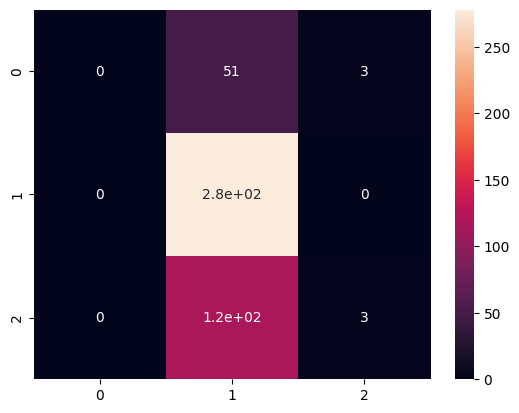

In [ ]:
print("\nConfig: [Bert-base-uncased | Auto Head | Train Head Only | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n" , eval_model(modelFined_Bert, test_dataset_bert_tf, test_labels_bert_tf))

In [ ]:
del modelFined_Bert

#### Fine-tuning - All layers, with auto generated classification head
Train the weights of the Classification head while holding the weights of the Pre-Trained model constant.

In [ ]:
modelFined_Bert_all = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

modelFined_Bert_all.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_280 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


##### Compiling and Training



In [ ]:
train_model_TFDS(modelFined_Bert_all, train_dataset_bert_tf, valid_dataset_bert_tf)

Epoch 1/5
170/170 [==============================] - 104s 340ms/step - loss: 0.4166 - accuracy: 0.8338 - val_loss: 0.1471 - val_accuracy: 0.9491
Epoch 2/5
170/170 [==============================] - 56s 327ms/step - loss: 0.1514 - accuracy: 0.9559 - val_loss: 0.1603 - val_accuracy: 0.9535
Epoch 3/5
170/170 [==============================] - 51s 299ms/step - loss: 0.0913 - accuracy: 0.9735 - val_loss: 0.1512 - val_accuracy: 0.9602
Epoch 4/5
170/170 [==============================] - 51s 299ms/step - loss: 0.0466 - accuracy: 0.9853 - val_loss: 0.1442 - val_accuracy: 0.9469
Epoch 5/5
170/170 [==============================] - 51s 299ms/step - loss: 0.0343 - accuracy: 0.9904 - val_loss: 0.1333 - val_accuracy: 0.9668


##### Evaluation: on test data

57/57 [==============================] - 8s 95ms/step

Config: [Bert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9245    0.9074    0.9159        54
           1     0.9751    0.9856    0.9803       278
           2     0.9407    0.9250    0.9328       120

    accuracy                         0.9602       452
   macro avg     0.9468    0.9393    0.9430       452
weighted avg     0.9599    0.9602    0.9600       452



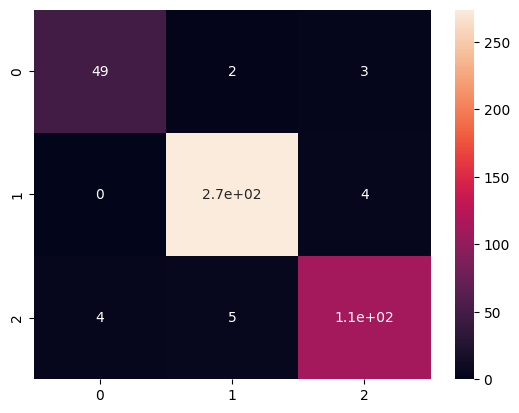

In [ ]:
print("\nConfig: [Bert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n" , eval_model(modelFined_Bert_all, test_dataset_bert_tf, test_labels_bert_tf))

In [ ]:
del modelFined_Bert_all

#### Conclusion
- Though it is supposed to be that larger models should perform better than smaller model, in this experiment the 'bert-base-uncased' model didn't beat 'distilbert-base-uncased' model.
- This is mainly because the greatness of model distilation. Knowledge distillation is a model compression technique whereby a small network (student) is taught by a larger trained neural network (teacher). The smaller network is trained to behave like the large neural network. This enables the deployment of such models on small devices, but at the same time guarantee the performance of distiled models.
- Therefore it is reasonable that these two models are equally excellent.

### Use 'twitter-roberta-base-sentiment'
- Now we try to use a model that is already pre-trained for sentiment analysis task (classification task), and it also has three labels which are exactly the same as our target labels.
- However, the difference is in that this model is trained on the dataset composed of Twitter posts and comments. There is still a huge difference between the contexts on twitter and the contexts in financial reports or articles. Soemtimes the judgment may vary in different contexts as well.
- So it's worth a try to fine-tune based on this model.

#### Tokenize and create new dataset

In [ ]:
tokenizer_twitter = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

dataset_twitter_tf = hf2tfds(dataset, tokenizer_twitter)
train_dataset_twitter_tf, valid_dataset_twitter_tf, test_dataset_twitter_tf = tdfs_split(dataset_twitter_tf)
test_labels_twitter_tf = np.array([y for x, y in test_dataset_twitter_tf])

del dataset_twitter_tf

#### Fine-tuning - Head only, with original classification head
Train the weights of the Classification head while holding the weights of the Pre-Trained model constant.

In [ ]:
modelFined_Twitter = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

modelFined_Twitter.layers[0].trainable = False

modelFined_Twitter.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 592,899
Non-trainable params: 124,055,040
_________________________________________________________________


##### Compiling and Training

In [ ]:
train_model_TFDS(modelFined_Twitter, train_dataset_twitter_tf, valid_dataset_twitter_tf)

Epoch 1/5
170/170 [==============================] - 39s 142ms/step - loss: 0.4333 - accuracy: 0.8441 - val_loss: 0.2714 - val_accuracy: 0.9181
Epoch 2/5
170/170 [==============================] - 21s 125ms/step - loss: 0.3114 - accuracy: 0.8941 - val_loss: 0.2240 - val_accuracy: 0.9181
Epoch 3/5
170/170 [==============================] - 21s 121ms/step - loss: 0.2612 - accuracy: 0.9088 - val_loss: 0.1886 - val_accuracy: 0.9336
Epoch 4/5
170/170 [==============================] - 21s 123ms/step - loss: 0.2526 - accuracy: 0.9051 - val_loss: 0.1721 - val_accuracy: 0.9403
Epoch 5/5
170/170 [==============================] - 20s 120ms/step - loss: 0.2265 - accuracy: 0.9176 - val_loss: 0.1625 - val_accuracy: 0.9403


##### Evaluation: on test data

57/57 [==============================] - 9s 87ms/step

Config: [Twitter-roberta-base-sentiment | Auto Head | Train Head Only | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.8305    0.9074    0.8673        54
           1     0.9601    0.9532    0.9567       278
           2     0.9060    0.8833    0.8945       120

    accuracy                         0.9292       452
   macro avg     0.8989    0.9147    0.9062       452
weighted avg     0.9303    0.9292    0.9295       452



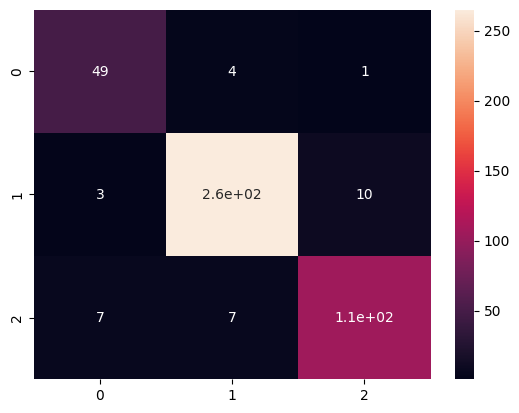

In [ ]:
print("\nConfig: [Twitter-roberta-base-sentiment | Auto Head | Train Head Only | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n" , eval_model(modelFined_Twitter, test_dataset_twitter_tf, test_labels_twitter_tf))

In [ ]:
del modelFined_Twitter

#### Fine-tuning - All layers, with auto generated classification head
Train the weights of the Classification head while holding the weights of the Pre-Trained model constant.

In [ ]:
modelFined_Twitter_all = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

modelFined_Twitter_all.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


##### Compiling and Training



In [ ]:
train_model_TFDS(modelFined_Twitter_all, train_dataset_twitter_tf, valid_dataset_twitter_tf)

Epoch 1/5
170/170 [==============================] - 114s 403ms/step - loss: 0.2299 - accuracy: 0.9346 - val_loss: 0.0710 - val_accuracy: 0.9757
Epoch 2/5
170/170 [==============================] - 49s 288ms/step - loss: 0.0937 - accuracy: 0.9743 - val_loss: 0.1267 - val_accuracy: 0.9646
Epoch 3/5
170/170 [==============================] - 48s 280ms/step - loss: 0.1078 - accuracy: 0.9721 - val_loss: 0.1382 - val_accuracy: 0.9602
Epoch 4/5
170/170 [==============================] - 48s 280ms/step - loss: 0.0878 - accuracy: 0.9728 - val_loss: 0.1533 - val_accuracy: 0.9668
Epoch 5/5
170/170 [==============================] - 47s 275ms/step - loss: 0.1016 - accuracy: 0.9743 - val_loss: 0.1818 - val_accuracy: 0.9513


##### Evaluation: on test data

57/57 [==============================] - 8s 93ms/step

Config: [Twitter-roberta-base-sentiment | Auto Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9273    0.9444    0.9358        54
           1     0.9485    0.9928    0.9701       278
           2     0.9906    0.8750    0.9292       120

    accuracy                         0.9558       452
   macro avg     0.9554    0.9374    0.9450       452
weighted avg     0.9571    0.9558    0.9552       452



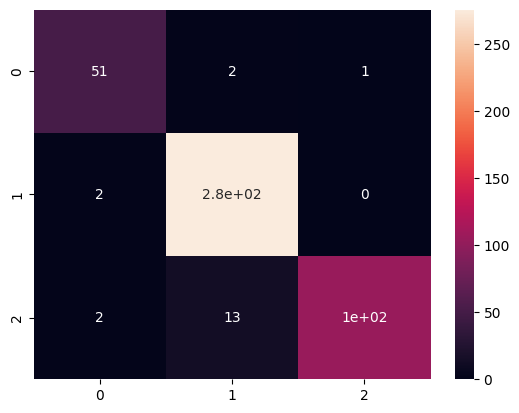

In [ ]:
print("\nConfig: [Twitter-roberta-base-sentiment | Auto Head | Train All Layers | All-Agree Dataset(TFDS) | Without Resampling]\nResult:\n" , eval_model(modelFined_Twitter_all, test_dataset_twitter_tf, test_labels_twitter_tf))

In [ ]:
del modelFined_Twitter_all

#### Conclusion
- When only training the classification head (embedded in the Twitter model already), the overall model performance exceeds the previous models quite a lot (accuracy 0.92 vs 0.79).
- However when training all layers, the fine-tuned twitter model does not outperform the fine-tuned bert models. But it still does a good job. I personally think it's because it's harder (may consume more time) to convert a highly specialized model to fit in another different task. That's why it's already an excellent model for Twitter sentiment analysis. In contract, the bert models are more general and more flexible to various tasks and situations, thus it could easily be trained well enough for our task.


## 7.Experiment with Fine-Tuning

*Relative difficulty*: low, but time-consuming

Does out of sample performance vary with changing
- the number of examples in Fine-Tuning
    - what is the smallest number that you think is sufficient
- **there are many choices of proper subsets of a given size**
    - **does it matter which one you choose ?**

### Different numbers of examples
- In this session, we try to compare the performance of models with different numbers of training dataset. Here for simplification, we only set three levels which are 400, 800 and 1200. Then we will compare the performance and see if there is significant difference between the results and estimate the smallest but sufficient number of traianing examples.

In [15]:
train_dataset_tf_400 = train_dataset_tf.shuffle(len(dataset), seed=42).take(400).prefetch(tf.data.AUTOTUNE)
train_dataset_tf_800 = train_dataset_tf.shuffle(len(dataset), seed=42).take(800).prefetch(tf.data.AUTOTUNE)
train_dataset_tf_1200 = train_dataset_tf.shuffle(len(dataset), seed=42).take(1200).prefetch(tf.data.AUTOTUNE)

#### Use 400 training examples

In [ ]:
modelFined_auto_400 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model_TFDS(modelFined_auto_400, train_dataset_tf_400, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_376', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5
50/50 [==============================] - 41s 338ms/step - loss: 0.7576 - accuracy: 0.6800 - val_loss: 0.4606 - val_accuracy: 0.7721
Epoch 2/5
50/50 [==============================] - 14s 273ms/step - loss: 0.4406 - accuracy: 0.8125 - val_loss: 0.2658 - val_accuracy: 0.9204
Epoch 3/5
50/50 [==============================] - 13s 257ms/step - loss: 0.2672 - accuracy: 0.9325 - val_loss: 0.2143 - val_accuracy: 0.9270
Epoch 4/5
50/50 [==============================] - 12s 245ms/step - loss: 0.1367 - accuracy: 0.9625 - val_loss: 0.1245 - val_accuracy: 0.9646
Epoch 5/5
50/50 [==============================] - 12s 247ms/step - loss: 0.1280 - accuracy: 0.9525 - val_loss: 0.1319 - val_accuracy: 0.9580


57/57 [==============================] - 4s 52ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/400) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.8966    0.9630    0.9286        54
           1     0.9675    0.9640    0.9658       278
           2     0.9231    0.9000    0.9114       120

    accuracy                         0.9469       452
   macro avg     0.9290    0.9423    0.9352       452
weighted avg     0.9472    0.9469    0.9469       452



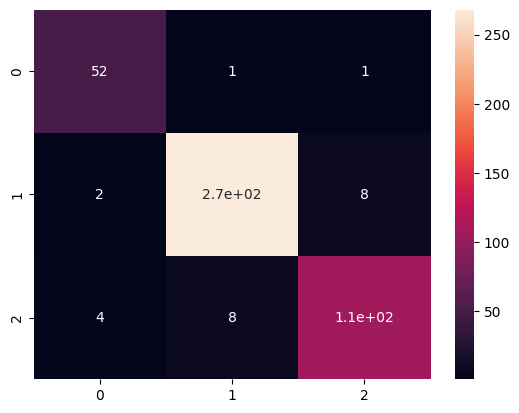

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/400) | Without Resampling]\nResult:\n" , eval_model(modelFined_auto_400, test_dataset_tf, test_labels_tf))

In [ ]:
del train_dataset_tf_400
del modelFined_auto_400

#### Use 800 training examples

In [ ]:
modelFined_auto_800 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model_TFDS(modelFined_auto_800, train_dataset_tf_800, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_396', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5
100/100 [==============================] - 48s 249ms/step - loss: 0.5254 - accuracy: 0.7912 - val_loss: 0.2127 - val_accuracy: 0.9336
Epoch 2/5
100/100 [==============================] - 18s 184ms/step - loss: 0.2101 - accuracy: 0.9300 - val_loss: 0.1435 - val_accuracy: 0.9513
Epoch 3/5
100/100 [==============================] - 17s 170ms/step - loss: 0.1360 - accuracy: 0.9575 - val_loss: 0.1267 - val_accuracy: 0.9491
Epoch 4/5
100/100 [==============================] - 17s 167ms/step - loss: 0.0748 - accuracy: 0.9750 - val_loss: 0.2242 - val_accuracy: 0.9248
Epoch 5/5
100/100 [==============================] - 17s 167ms/step - loss: 0.0704 - accuracy: 0.9775 - val_loss: 0.1502 - val_accuracy: 0.9602


57/57 [==============================] - 5s 52ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/800) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9259    0.9259    0.9259        54
           1     0.9386    0.9892    0.9632       278
           2     0.9619    0.8417    0.8978       120

    accuracy                         0.9425       452
   macro avg     0.9421    0.9189    0.9290       452
weighted avg     0.9433    0.9425    0.9414       452



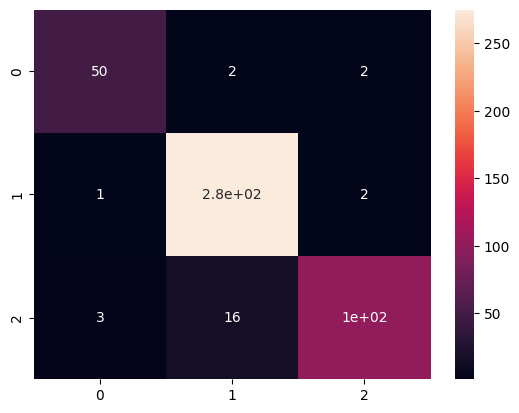

In [ ]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/800) | Without Resampling]\nResult:\n" , eval_model(modelFined_auto_800, test_dataset_tf, test_labels_tf))

In [ ]:
del train_dataset_tf_800
del modelFined_auto_800

#### Use 1200 training examples

In [16]:
modelFined_auto_1200 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model_TFDS(modelFined_auto_1200, train_dataset_tf_1200, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_58']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
150/150 [==============================] - 71s 256ms/step - loss: 0.4658 - accuracy: 0.8133 - val_loss: 0.1871 - val_accuracy: 0.9403
Epoch 2/5
150/150 [==============================] - 25s 170ms/step - loss: 0.1292 - accuracy: 0.9642 - val_loss: 0.1902 - val_accuracy: 0.9425
Epoch 3/5
150/150 [==============================] - 25s 168ms/step - loss: 0.1031 - accuracy: 0.9658 - val_loss: 0.1752 - val_accuracy: 0.9358
Epoch 4/5
150/150 [==============================] - 24s 157ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.1619 - val_accuracy: 0.9558
Epoch 5/5
150/150 [==============================] - 23s 154ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.1562 - val_accuracy: 0.9535


57/57 [==============================] - 4s 48ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/1200) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9048    0.9500    0.9268        60
           1     0.9777    0.9705    0.9741       271
           2     0.9333    0.9256    0.9295       121

    accuracy                         0.9558       452
   macro avg     0.9386    0.9487    0.9435       452
weighted avg     0.9561    0.9558    0.9559       452



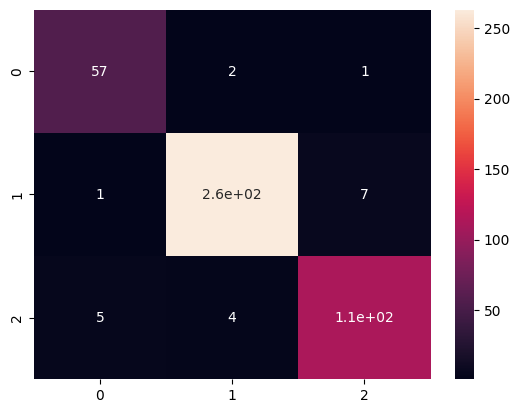

In [20]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/1200) | Without Resampling]\nResult:\n" , eval_model(modelFined_auto_1200, test_dataset_tf, test_labels_tf))

In [21]:
del train_dataset_tf_1200
del modelFined_auto_1200

#### Conclusion
- The models perform better with more training samples.
- The accuracies of models trained on 400 samples and 800 samples are both around 0.94, but it jumps to 0.95 when the number of samples comes to 1200. This may indicate **the smallest number that is sufficient to make the accuracy above 0.95 is between 800 and 1200, let's say 1000 is an appropriate number.**

### Different subsets of a given size
- From the last session, we have found that more training examples lead to higher accuracy, and we have found the sufficient number for a 0.95 accuracy is around 1000.
- Given the three subsets (all-agree/50-agree/66-agree/75-agree), it's better to use as many examples as we can to train the models. Therefore, we will find the minumum size of the three subsets and truncate all the three subsets to that size (larger than 1000), and then compare the performance of models trained on each subset with the same size.

In [26]:
size = min(len(dataset_tf_50), len(dataset_tf_66), len(dataset_tf_75), len(dataset_tf))

dataset_tf_50GS = dataset_tf_50.take(size)
dataset_tf_66GS = dataset_tf_66.take(size)
dataset_tf_75GS = dataset_tf_75.take(size)
dataset_tf_allGS = dataset_tf.take(size)

train_dataset_tf_50GS, valid_dataset_tf_50GS, test_dataset_tf_50GS = tdfs_split(dataset_tf_50GS)
test_labels_tf_50GS = np.array([y for x, y in test_dataset_tf_50GS])

train_dataset_tf_66GS, valid_dataset_tf_66GS, test_dataset_tf_66GS = tdfs_split(dataset_tf_66GS)
test_labels_tf_66GS = np.array([y for x, y in test_dataset_tf_66GS])

train_dataset_tf_75GS, valid_dataset_tf_75GS, test_dataset_tf_75GS = tdfs_split(dataset_tf_75GS)
test_labels_tf_75GS = np.array([y for x, y in test_dataset_tf_75GS])

train_dataset_tf_allGS, valid_dataset_tf_allGS, test_dataset_tf_allGS = tdfs_split(dataset_tf_allGS)
test_labels_tf_allGS = np.array([y for x, y in test_dataset_tf_allGS])

del dataset_tf_50GS
del dataset_tf_66GS
del dataset_tf_75GS
del dataset_tf_allGS

#### Create models

In [27]:
modelFined_50GS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_66GS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_75GS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_allGS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_78', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

#### Use 50-agree dataset of a given size

In [28]:
train_model_TFDS(modelFined_50GS, train_dataset_tf_50GS, valid_dataset_tf_50GS)

Epoch 1/5
170/170 [==============================] - 65s 220ms/step - loss: 0.6542 - accuracy: 0.7287 - val_loss: 0.4427 - val_accuracy: 0.8385
Epoch 2/5
170/170 [==============================] - 28s 166ms/step - loss: 0.3086 - accuracy: 0.8853 - val_loss: 0.4171 - val_accuracy: 0.8584
Epoch 3/5
170/170 [==============================] - 27s 156ms/step - loss: 0.1322 - accuracy: 0.9529 - val_loss: 0.5937 - val_accuracy: 0.7876
Epoch 4/5
170/170 [==============================] - 26s 153ms/step - loss: 0.0770 - accuracy: 0.9750 - val_loss: 0.6982 - val_accuracy: 0.8230
Epoch 5/5
170/170 [==============================] - 26s 155ms/step - loss: 0.0682 - accuracy: 0.9757 - val_loss: 0.6709 - val_accuracy: 0.8230


57/57 [==============================] - 4s 48ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 50-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.7424    0.6806    0.7101        72
           1     0.8560    0.8199    0.8376       261
           2     0.6544    0.7479    0.6980       119

    accuracy                         0.7788       452
   macro avg     0.7509    0.7495    0.7486       452
weighted avg     0.7848    0.7788    0.7805       452



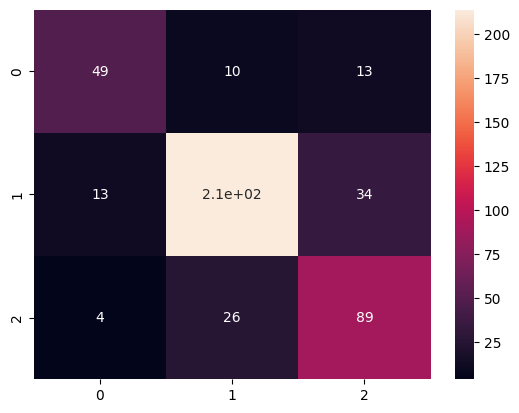

In [29]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 50-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_50GS, test_dataset_tf_50GS, test_labels_tf_50GS))

In [30]:
del modelFined_50GS

#### Use 66-agree dataset of a given size

In [31]:
train_model_TFDS(modelFined_66GS, train_dataset_tf_66GS, valid_dataset_tf_66GS)

Epoch 1/5
170/170 [==============================] - 66s 229ms/step - loss: 0.5335 - accuracy: 0.7949 - val_loss: 0.3815 - val_accuracy: 0.8540
Epoch 2/5
170/170 [==============================] - 28s 164ms/step - loss: 0.2098 - accuracy: 0.9338 - val_loss: 0.3855 - val_accuracy: 0.8628
Epoch 3/5
170/170 [==============================] - 26s 155ms/step - loss: 0.0867 - accuracy: 0.9765 - val_loss: 0.5000 - val_accuracy: 0.8673
Epoch 4/5
170/170 [==============================] - 28s 165ms/step - loss: 0.0470 - accuracy: 0.9868 - val_loss: 0.6183 - val_accuracy: 0.8407
Epoch 5/5
170/170 [==============================] - 26s 151ms/step - loss: 0.0657 - accuracy: 0.9816 - val_loss: 0.4601 - val_accuracy: 0.8650


57/57 [==============================] - 5s 48ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 66-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.8600    0.7414    0.7963        58
           1     0.9004    0.8835    0.8918       266
           2     0.7660    0.8438    0.8030       128

    accuracy                         0.8540       452
   macro avg     0.8421    0.8229    0.8304       452
weighted avg     0.8571    0.8540    0.8544       452



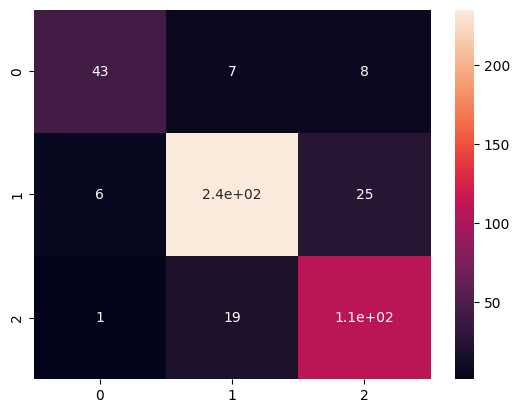

In [32]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 66-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_66GS, test_dataset_tf_66GS, test_labels_tf_66GS))

In [33]:
del modelFined_66GS

#### Use 75-agree dataset of a given size

In [34]:
train_model_TFDS(modelFined_75GS, train_dataset_tf_75GS, valid_dataset_tf_75GS)

Epoch 1/5
170/170 [==============================] - 66s 230ms/step - loss: 0.5366 - accuracy: 0.7890 - val_loss: 0.3486 - val_accuracy: 0.8761
Epoch 2/5
170/170 [==============================] - 27s 161ms/step - loss: 0.1985 - accuracy: 0.9331 - val_loss: 0.3045 - val_accuracy: 0.8761
Epoch 3/5
170/170 [==============================] - 27s 162ms/step - loss: 0.0875 - accuracy: 0.9750 - val_loss: 0.4797 - val_accuracy: 0.8739
Epoch 4/5
170/170 [==============================] - 26s 155ms/step - loss: 0.0544 - accuracy: 0.9853 - val_loss: 0.3839 - val_accuracy: 0.8960
Epoch 5/5
170/170 [==============================] - 25s 150ms/step - loss: 0.0112 - accuracy: 0.9985 - val_loss: 0.4740 - val_accuracy: 0.8960


57/57 [==============================] - 5s 48ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9143    0.7805    0.8421        41
           1     0.9490    0.9394    0.9442       297
           2     0.8455    0.9123    0.8776       114

    accuracy                         0.9181       452
   macro avg     0.9029    0.8774    0.8880       452
weighted avg     0.9197    0.9181    0.9181       452



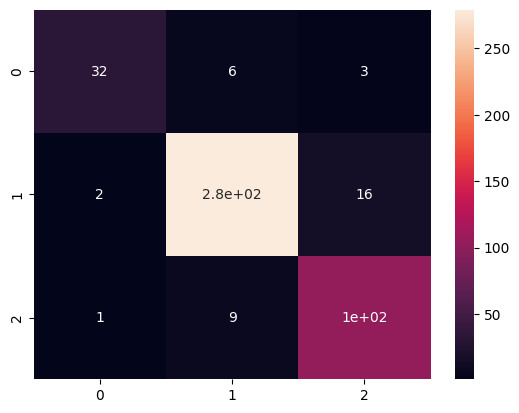

In [35]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_75GS, test_dataset_tf_75GS, test_labels_tf_75GS))

In [36]:
del modelFined_75GS

#### Use All-agree dataset of a given size



In [37]:
train_model_TFDS(modelFined_allGS, train_dataset_tf_allGS, valid_dataset_tf_allGS)

Epoch 1/5
170/170 [==============================] - 62s 208ms/step - loss: 0.4527 - accuracy: 0.8191 - val_loss: 0.1824 - val_accuracy: 0.9491
Epoch 2/5
170/170 [==============================] - 27s 160ms/step - loss: 0.1312 - accuracy: 0.9610 - val_loss: 0.1721 - val_accuracy: 0.9469
Epoch 3/5
170/170 [==============================] - 26s 154ms/step - loss: 0.0845 - accuracy: 0.9779 - val_loss: 0.1154 - val_accuracy: 0.9624
Epoch 4/5
170/170 [==============================] - 27s 156ms/step - loss: 0.0266 - accuracy: 0.9934 - val_loss: 0.1725 - val_accuracy: 0.9535
Epoch 5/5
170/170 [==============================] - 26s 154ms/step - loss: 0.0414 - accuracy: 0.9831 - val_loss: 0.3001 - val_accuracy: 0.9358


57/57 [==============================] - 4s 47ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9615    0.8333    0.8929        60
           1     0.9539    0.9926    0.9729       271
           2     0.9237    0.9008    0.9121       121

    accuracy                         0.9469       452
   macro avg     0.9464    0.9089    0.9260       452
weighted avg     0.9468    0.9469    0.9460       452



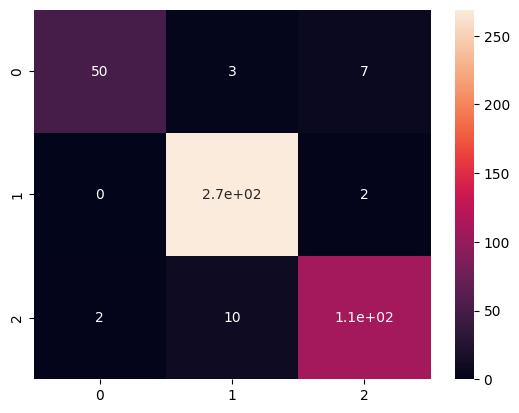

In [38]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_allGS, test_dataset_tf_allGS, test_labels_tf_allGS))

In [39]:
del modelFined_allGS

#### Conclusion
- Comparing the above results, we can get the same conclusion as that in the 'Use different flavors of the dataset' part. The higher the level of agreement is, the higher the accuracy will be.
- Using only 1000 number of examples, the accuracies are a bit lower than using all the examples (refer to results in the 'Use different flavors of the dataset' part). However, it is still satisfying in that we can get about the same results with a much smaller data set, which saves time and computing resources.
- This further verifies that '1000' is a suitable small number which is sufficient in our fine-tuning process.

## 8.In-context learning

*Relative difficulty: low but fun !*

Can you use few-shot learning successfully (i.e., no further training) ?

It would be great to do this for Financial PhraseBank but the sentences may be too long
- pre-trained models have maximum sequence lengths that may be too small

**Propose some interesting task related to Finance and try to achieve Few Shot Learning on the task.**

In [1]:
from transformers import pipeline
from transformers import GPTNeoForCausalLM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.9 MB/s eta 0:00:00


### Sentiment Analysis
- Same as the task of this project, we try to use in-context learning to classify if the input sentence is negative, neutral or positive. 
- Here we directly apply the classifier based on "facebook/bart-large-mnli" to the test_dataset we created before and compare the accuracies with the previous experiments.

In [ ]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
import random

few_shot_preds = []
label_map = {'negative':0, 'neutral':1, 'positive':2}
candidate_labels = ['negative', 'neutral', 'positive']

random.seed(2)
index = [random.randint(0, len(test_dataset)) for _ in range(10)]

for i in index: 
  sentence = test_texts[i]
  pred = label_map[classifier(sentence, candidate_labels)['labels'][0]]
  print('Sentence: {}\nTrue label: {}. Predicted label: {}\n'.format(sentence, test_labels[i], pred))

Sentence: Kalnapilio-Tauro Grupe ( Kalnapilis-Tauras Group ) , which is owned by Denmark 's Royal Unibrew , raised its market share to 25.18 percent from 23.74 percent , as beer sales for the seven months jumped by 14.5 percent to 40.5 million liters .
True label: 2. Predicted label: 2

Sentence: Finnlines will announce in week 17 of 2006 what measures it will take to tackle the situation .
True label: 1. Predicted label: 0

Sentence: 26 January 2011 - Finnish metal products company Componenta Oyj ( HEL : CTH1V ) said yesterday its net loss narrowed to EUR500 ,000 in the last quarter of 2010 from EUR5 .3 m for the same period a year earlier .
True label: 2. Predicted label: 0

Sentence: Total value of the contract is about EUR 10mn .
True label: 1. Predicted label: 2

Sentence: Unbelievably , the company that makes them - Fiskars Corporation - was formed in 1649 when a Dutch merchant named Peter Thorwoste was given a charter to establish a blast furnace and forging operation in the sma

### Topic Classification
- Besides sentiment analysis, I think it's a good idea to implement topic classification with the help of in-context learning. **According to The Wall Street Journal, articles usually belong to one of the following sections: Politics, Economy, Businuss, Tech, Markets. Therefore, I want to find if few-shot learning can help classify a given sentence correctly to the real topic it belongs to. 
- To verify this, I randomly select some sentences from various sections in Wall Street Journal, most of which are article titles, as input of the model, and check the results respectively.

In [25]:
test_pool = {"A Debt Deal Could Help Solve the Country’s Inflation Problem": "economy",
             "Eight Trump Electors Granted Immunity in Georgia Investigation": "politics",
             "How Big Companies Choose Who Is Laid Off": 'business',
             "Forget ChatGPT. These Are the Best AI-Powered Apps.": "technology",
             "Investors Flock to Safety Plays, but Stock ‘FOMO’ Lingers": 'market'}
candidate_labels = ['politics', 'economy', 'business', 'technology', 'market']

In [35]:
for sentence in test_pool.keys():
    print('Sentence: {}\nTrue topic: {}. Top 3 predicted topics: {}\n'.format(sentence, test_pool[sentence],classifier(sentence, candidate_labels)['labels'][:3]))

Sentence: A Debt Deal Could Help Solve the Country’s Inflation Problem
True topic: economy, top 3 predicted topics: ['economy', 'market', 'business'].

Sentence: Eight Trump Electors Granted Immunity in Georgia Investigation
True topic: politics, top 3 predicted topics: ['politics', 'market', 'business'].

Sentence: How Big Companies Choose Who Is Laid Off
True topic: business, top 3 predicted topics: ['business', 'economy', 'market'].

Sentence: Forget ChatGPT. These Are the Best AI-Powered Apps.
True topic: technology, top 3 predicted topics: ['technology', 'market', 'business'].

Sentence: Investors Flock to Safety Plays, but Stock ‘FOMO’ Lingers
True topic: market, top 3 predicted topics: ['market', 'business', 'economy'].



- We can see the result is quite good!
- Then we try to implement this classifier to some of the sentences in Financial Bankphrase dataset just for fun!

In [38]:
test_pool_fin = test_texts[:10]

for sentence in test_pool_fin:
  print('Sentence: {}\nTop 3 predicted topics: {}\n'.format(sentence,classifier(sentence, candidate_labels)['labels'][:3]))


Sentence: Its product portfolio comprises harvesters , forwarders , harvester heads , as well as cranes and loaders .
Top 3 predicted topics: ['technology', 'business', 'market']

Sentence: These sections will be put into place to form the load-bearing steel structure of the bridge , '' says Sami Eronen , Senior Vice President , Infrastructure and Northern Europe , Ruukki Construction .
Top 3 predicted topics: ['technology', 'business', 'economy']

Sentence: CapMan said the deal 's effect on its cash flow for 2009 totals EUR3 .4 m , but the transaction would not affect its financial results for 2009 as it was executed at fair value .
Top 3 predicted topics: ['business', 'market', 'economy']

Sentence: However , the broker gave an `` outperform '' recommendation on the stock .
Top 3 predicted topics: ['market', 'business', 'economy']

Sentence: Honkarakenne also decided yesterday to sell 88,500 of its B series shares to key staff members for EUR2 .9 per share .
Top 3 predicted topics: [

- From the results, we can find 'business', 'market' and 'economy' are the closest three topics. This is reasonable because the dataset itself is about the sentences from financial news, which is mostly related to these topics.

In [40]:
print("Done")

Done
